In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eur-usd-forex-pair-historical-data-2002-2019/eurusd_hour.csv
/kaggle/input/eur-usd-forex-pair-historical-data-2002-2019/eurusd_minute.csv
/kaggle/input/eur-usd-forex-pair-historical-data-2002-2019/eurusd_news.csv


# Cell 1: Import Libraries

In [48]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Cell 2: Load and Preprocess Data

In [49]:
# Cell 2: Load and Preprocess Data
def load_data(filepath):
    # Load the dataset from the Kaggle file directory
    df = pd.read_csv(filepath, parse_dates=['Date'], infer_datetime_format=True)
    
    # Combining 'Date' and 'Time' columns to create a DateTime index
    df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'])
    df.set_index('DateTime', inplace=True)
    df.drop(columns=['Date', 'Time'], inplace=True)

    return df

# Use your uploaded dataset name on Kaggle (you can find it in the sidebar)
df = load_data('/kaggle/input/eur-usd-forex-pair-historical-data-2002-2019/eurusd_hour.csv')
df.head()

/tmp/ipykernel_30/2332144496.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(filepath, parse_dates=['Date'], infer_datetime_format=True)


,BO,BH,BL,BC,BCh,AO,AH,AL,AC,ACh
DateTime,,,,,,,,,,
2005-05-02 00:00:00,1.2852,1.2852,1.2840,1.2844,-0.0008,1.2854,1.2854,1.2842,1.2846,-0.0008
2005-05-02 01:00:00,1.2844,1.2848,1.2839,1.2842,-0.0002,1.2846,1.2850,1.2841,1.2844,-0.0002
2005-05-02 02:00:00,1.2843,1.2854,1.2841,1.2851,0.0008,1.2845,1.2856,1.2843,1.2853,0.0008
2005-05-02 03:00:00,1.2851,1.2859,1.2850,1.2851,0.0000,1.2853,1.2861,1.2852,1.2853,0.0000
2005-05-02 04:00:00,1.2852,1.2859,1.2849,1.2855,0.0003,1.2854,1.2861,1.2851,1.2857,0.0003


# Cell 3: Data Preprocessing

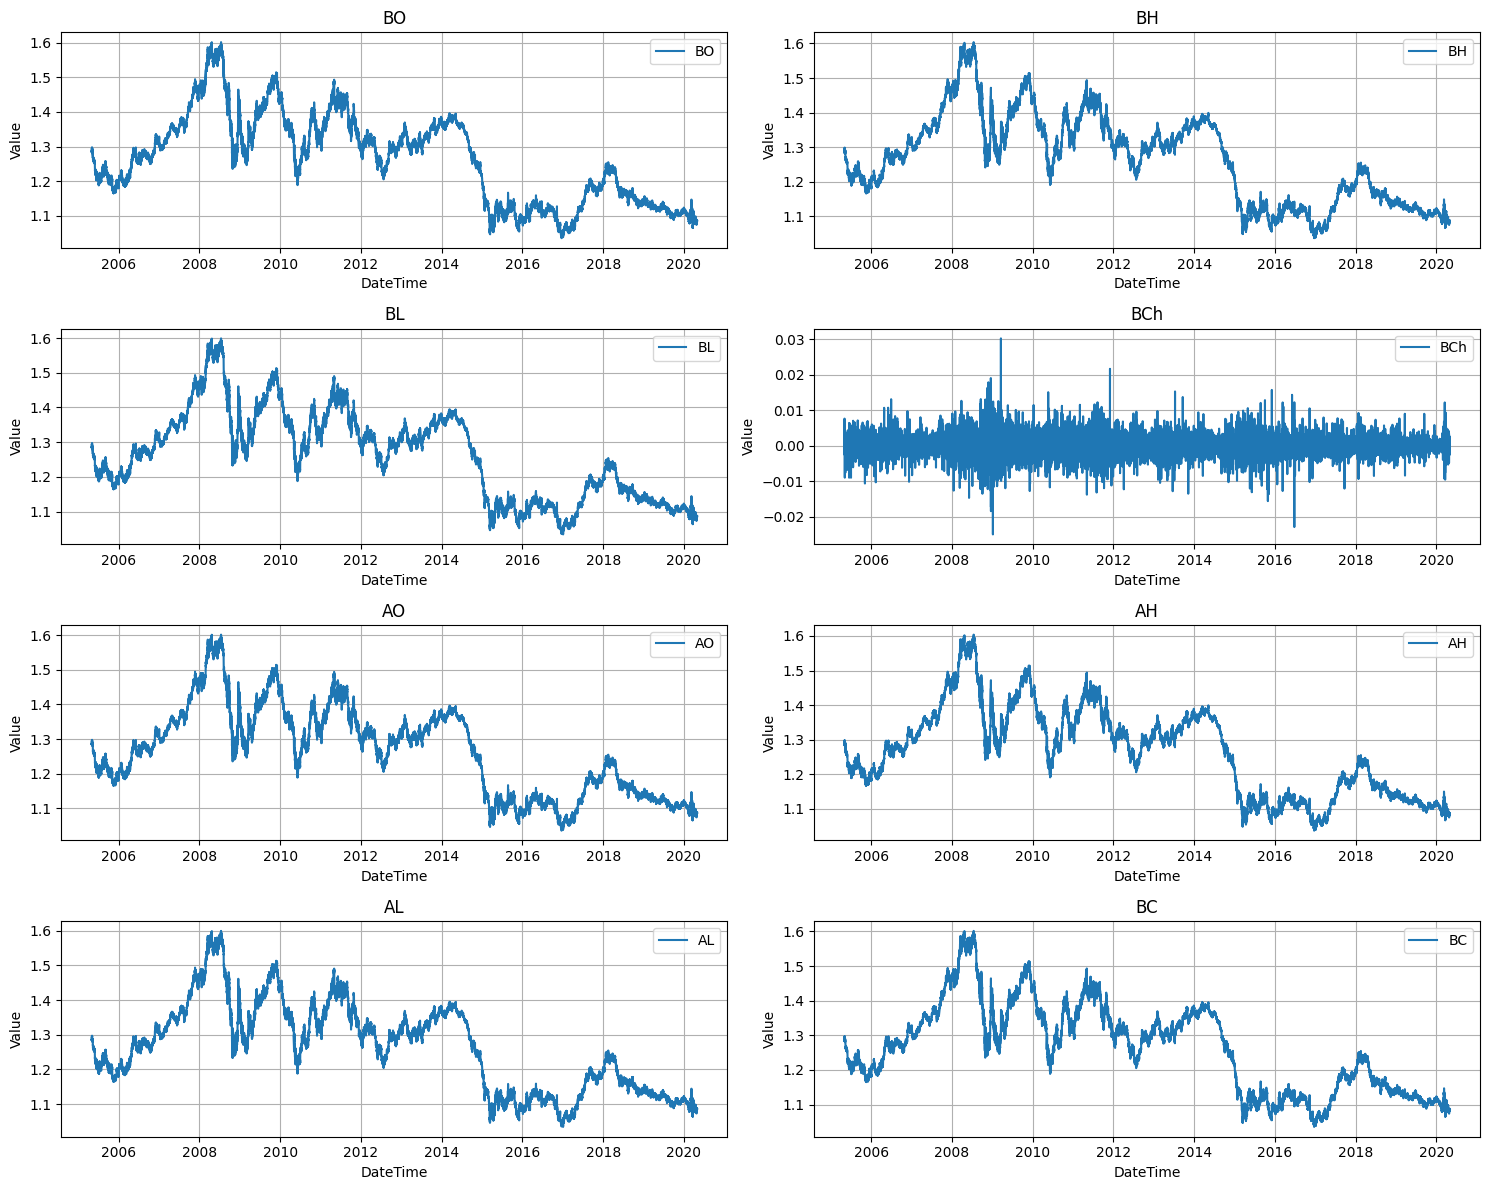

In [50]:
# Cell 3: Data Preprocessing with Graphs
def preprocess_data(df):
    # Select all features and the target (which is now the entire dataframe)
    features = df[['BO', 'BH', 'BL', 'BCh', 'AO', 'AH', 'AL', 'BC']]
    
    # Normalize features using MinMaxScaler
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)

    # Plot each feature to visualize the data trends
    plt.figure(figsize=(15, 12))
    
    # Plot each column
    for i, column in enumerate(features.columns, 1):
        plt.subplot(4, 2, i)
        plt.plot(df.index, df[column], label=column)
        plt.title(column)
        plt.xlabel('DateTime')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

    return scaled_features, scaler

scaled_features, scaler = preprocess_data(df)


# Cell 4: Create Sequences for LSTM Input

In [51]:
# Cell 4: Create Sequences for LSTM Input
def create_sequences(data, seq_length=60):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

# Create sequences
seq_length = 60  # Adjust this value based on your data
x, y = create_sequences(scaled_features, seq_length)

# Split the dataset into training and testing sets (80% training, 20% testing)
split = int(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

print(f"Training set shape: {x_train.shape}, {y_train.shape}")
print(f"Testing set shape: {x_test.shape}, {y_test.shape}")


Training set shape: (74419, 60, 8), (74419, 8)
Testing set shape: (18605, 60, 8), (18605, 8)


# Cell 5: Build the LSTM Model

In [52]:
# Cell 5: Build the LSTM Model
def build_model(input_shape, output_dim):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim))  # Output layer for predicting all columns
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mape'])  # Mean Absolute Percentage Error as a metric
    return model

# Build the model using the training data's shape
model = build_model((x_train.shape[1], x_train.shape[2]), y_train.shape[1])
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,408 (126.59 KB)

 Trainable params: 32,408 (126.59 KB)

 Non-trainable params: 0 (0.00 B)

# Cell 6: Train the Model

Epoch 1/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0165 - mape: 1179.2841 - val_loss: 4.9660e-04 - val_mape: 2150.1340
Epoch 2/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0018 - mape: 3584.0283 - val_loss: 2.8258e-04 - val_mape: 1642.7325
Epoch 3/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 8.5425e-04 - mape: 894.9011 - val_loss: 1.3453e-04 - val_mape: 867.7635
Epoch 4/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 4.9899e-04 - mape: 351.4780 - val_loss: 1.0701e-04 - val_mape: 850.5541
Epoch 5/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 3.7626e-04 - mape: 626.4195 - val_loss: 1.4597e-04 - val_mape: 1050.5557
Epoch 6/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 3.2774e-04 - mape: 540.2054 - val_loss: 1.2854e-04 - val_mape: 385.4377
Epoch 7/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 3.2255e-04 - mape: 919.2242 - val_loss: 3.0671e-04 - val_mape: 1638.5364
Epoch 8/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 3.0506e-04 - mape

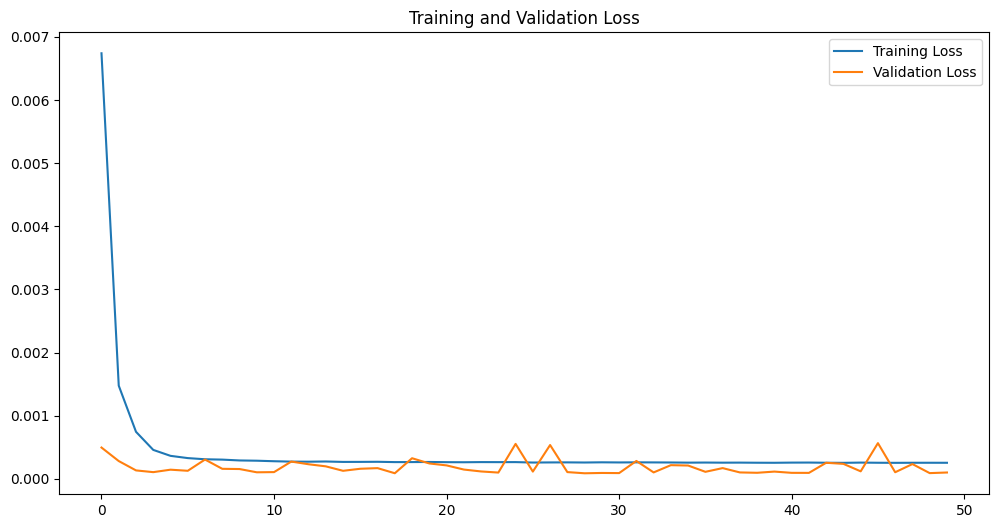

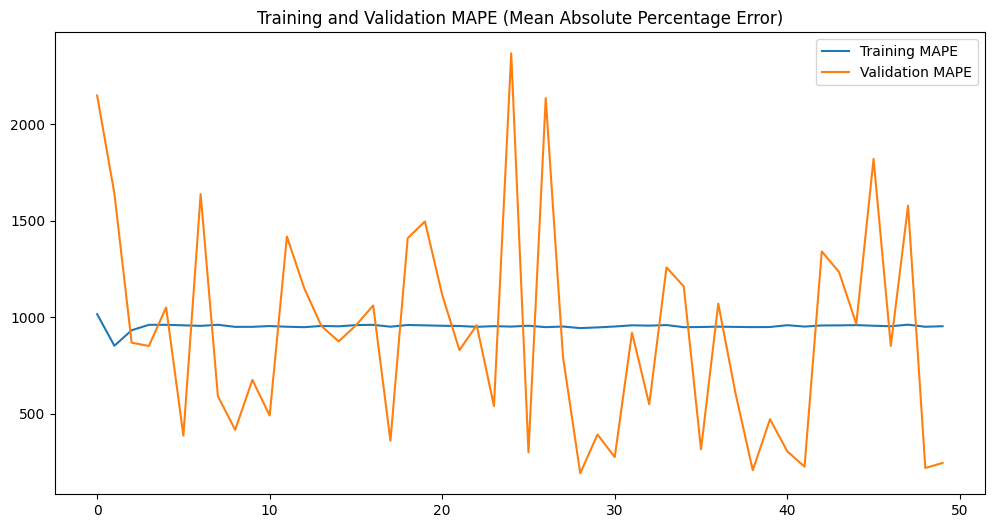

In [53]:
# Cell 6: Train the Model with MAPE Metric
def train_model(model, x_train, y_train, epochs=50, batch_size=64):
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    return history

# Train the model
history = train_model(model, x_train, y_train, epochs=50, batch_size=64)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation MAPE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mape'], label='Training MAPE')
plt.plot(history.history['val_mape'], label='Validation MAPE')
plt.title('Training and Validation MAPE (Mean Absolute Percentage Error)')
plt.legend()
plt.show()


# Cell 7: Plot Validation vs Actual Prices During Training

582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


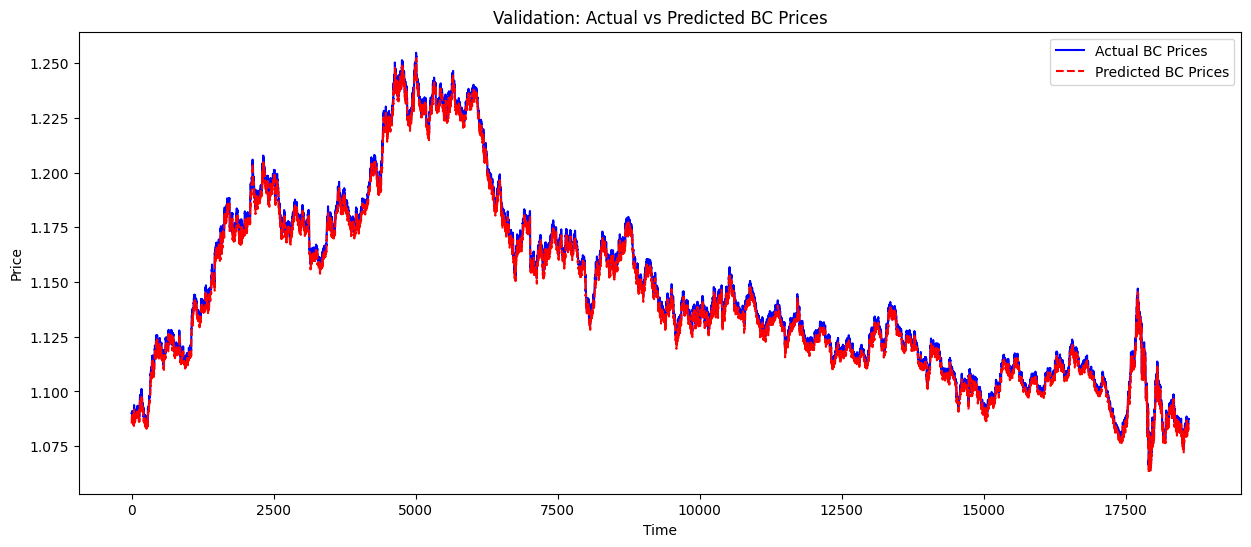

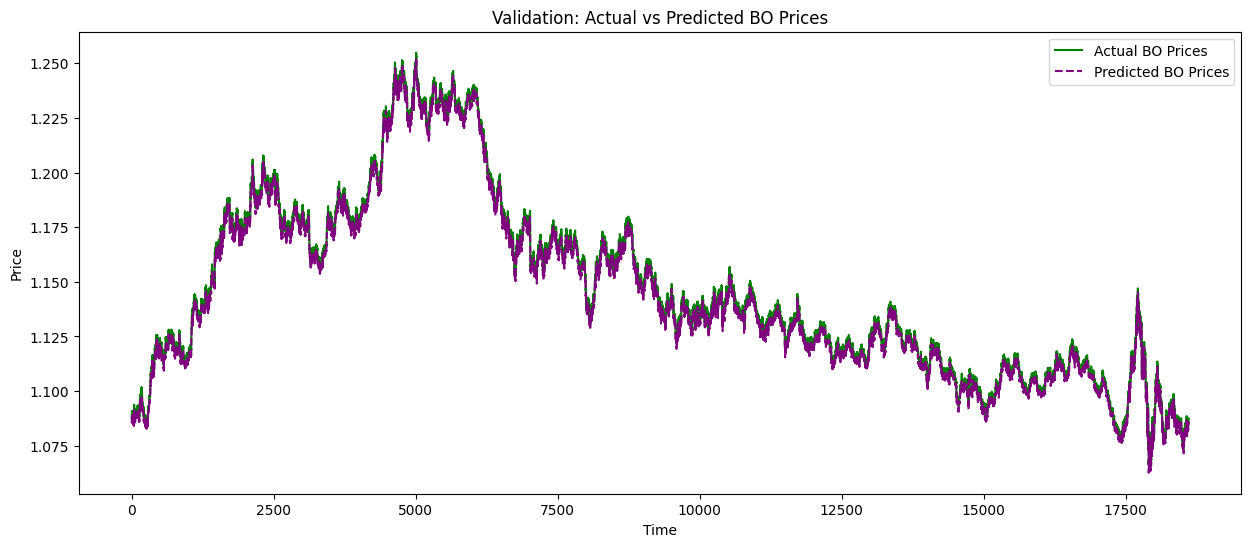

In [54]:
# Cell 7: Plot Validation vs Actual Prices During Training
def plot_validation_results(model, x_test, y_test, scaler):
    # Predict on the test set
    predictions = model.predict(x_test)

    # Prepare placeholder arrays to match the number of features in the original scaled data
    predictions_extended = np.zeros_like(y_test)
    y_test_extended = np.zeros_like(y_test)

    # Assign the predicted and actual values to the extended arrays
    predictions_extended[:, :] = predictions  # Multi-column assignment
    y_test_extended[:, :] = y_test            # Multi-column assignment

    # Inverse transform the predictions and actual values using the scaler
    predictions_rescaled = scaler.inverse_transform(predictions_extended)
    y_test_rescaled = scaler.inverse_transform(y_test_extended)

    # Plot actual vs predicted values for a few columns (e.g., 'BC' and 'BO' as examples)
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_rescaled[:, -1], color='blue', label='Actual BC Prices')  # Plotting 'BC' (last column)
    plt.plot(predictions_rescaled[:, -1], color='red', linestyle='dashed', label='Predicted BC Prices')  # Plotting 'BC'
    plt.title('Validation: Actual vs Predicted BC Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Plot another column if needed, e.g., 'BO'
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_rescaled[:, 0], color='green', label='Actual BO Prices')  # Plotting 'BO' (first column)
    plt.plot(predictions_rescaled[:, 0], color='purple', linestyle='dashed', label='Predicted BO Prices')  # Plotting 'BO'
    plt.title('Validation: Actual vs Predicted BO Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Call the function to plot results
plot_validation_results(model, x_test, y_test, scaler)


# Cell 8: Predict Future Prices Using Rolling Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

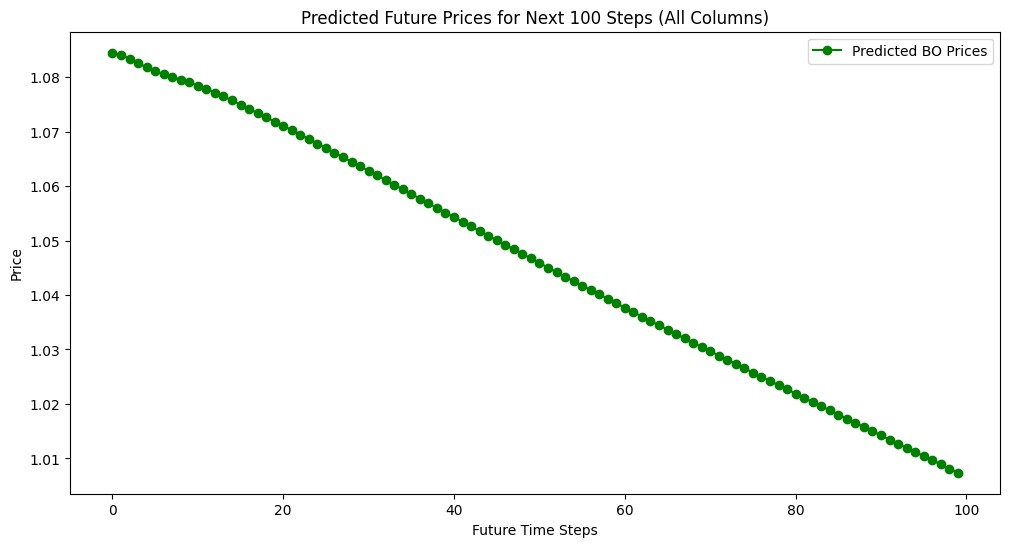

In [55]:
# Cell 8: Predict Future Prices Using Rolling Predictions for All Columns
def predict_future_prices_rolling_all_columns(model, data, scaler, future_steps=10):
    # Get the most recent window of data based on the sequence length used during training
    last_sequence = data[-50:]  # Replace 50 with the sequence length used in training
    predicted_prices = []

    for _ in range(future_steps):
        # Reshape the data to match LSTM input shape (1, sequence_length, number of features)
        last_sequence_reshaped = last_sequence[np.newaxis, :, :]

        # Predict the next set of values for all columns
        next_values = model.predict(last_sequence_reshaped)[0]
        predicted_prices.append(next_values)

        # Update the last sequence by appending the predicted values and removing the oldest entry
        last_sequence = np.vstack((last_sequence[1:], next_values))

    # Inverse transform the predictions to get them back to the original scale
    predicted_prices = np.array(predicted_prices)
    predicted_prices_rescaled = scaler.inverse_transform(predicted_prices)

    return predicted_prices_rescaled

# Predict future prices for all columns
future_steps = 100  # Number of future steps to predict
predicted_future_prices_all_columns = predict_future_prices_rolling_all_columns(model, scaled_features, scaler, future_steps)

# Plot the predicted future prices (Example: Only showing the first column, BO, as an example)
plt.figure(figsize=(12, 6))
plt.plot(predicted_future_prices_all_columns[:, 0], color='green', marker='o', label='Predicted BO Prices')
plt.title(f'Predicted Future Prices for Next {future_steps} Steps (All Columns)')
plt.xlabel('Future Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()


# Cell 9: Make Predictions

582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


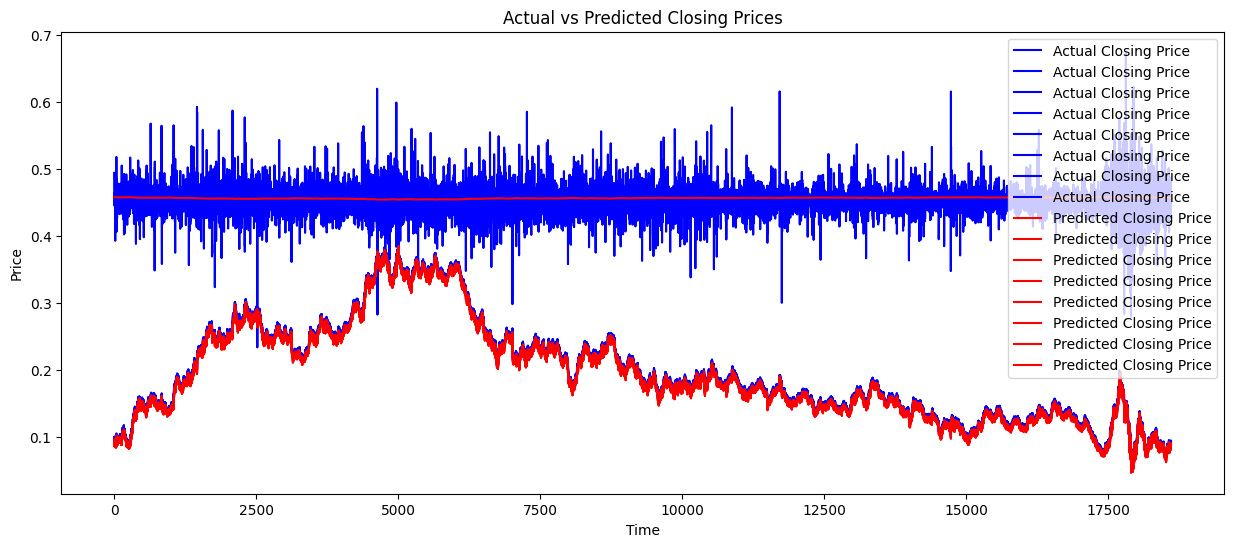

In [56]:
# Cell 7: Make Predictions
predictions = model.predict(x_test)

# Plot the actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_test, color='blue', label='Actual Closing Price')
plt.plot(predictions, color='red', label='Predicted Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Cell 10: Predict Future Forex Prices

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


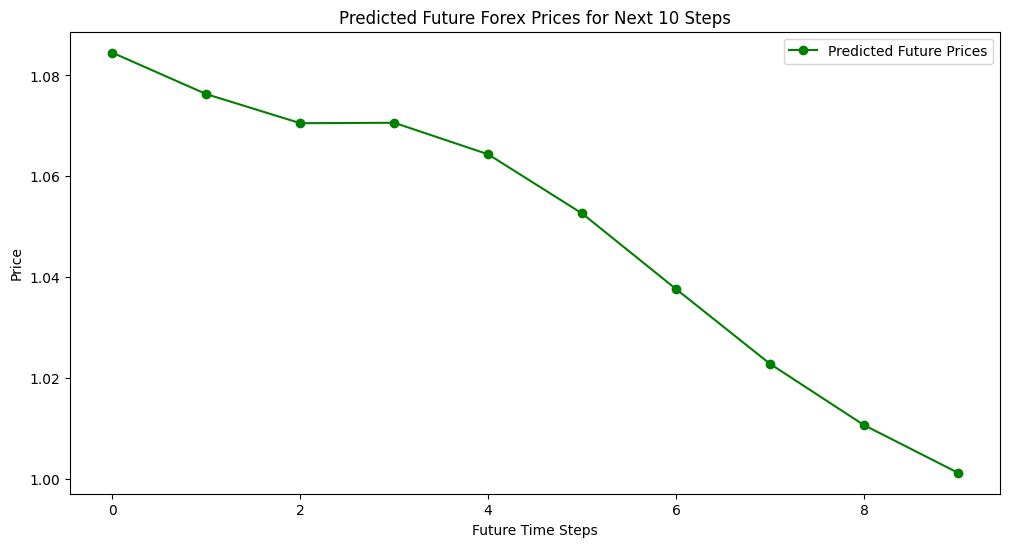

In [60]:
# Cell 8: Predict Future Forex Prices
def predict_future_prices(model, data, scaler, future_steps=10):
    # Get the most recent window of data based on the sequence length used during training
    last_sequence = data[-50:]  # Replace 50 with the sequence length used in training
    predicted_prices = []

    for _ in range(future_steps):
        # Reshape the data to match LSTM input shape (1, sequence_length, number of features)
        last_sequence_reshaped = last_sequence[np.newaxis, :, :]

        # Predict the next price
        next_price = model.predict(last_sequence_reshaped)[0][0]
        predicted_prices.append(next_price)

        # Update the last sequence by appending the predicted price and removing the oldest entry
        new_row = np.append(last_sequence[-1, 1:], next_price)  # Append the predicted closing price (BC)
        last_sequence = np.vstack((last_sequence[1:], new_row))

    # Create a placeholder with the same number of features as the original data
    predicted_prices_extended = np.zeros((future_steps, data.shape[1]))
    predicted_prices_extended[:, -1] = predicted_prices  # Place predicted prices in the last column (assuming 'BC' was last)

    # Inverse transform only the last column which corresponds to the predicted closing price
    predicted_prices_original_scale = scaler.inverse_transform(predicted_prices_extended)[:, -1]

    return predicted_prices_original_scale

# Predict future prices
future_steps = 10  # Number of future steps to predict
predicted_future_prices = predict_future_prices(model, scaled_features, scaler, future_steps)

# Plot the predicted future prices
plt.figure(figsize=(12, 6))
plt.plot(predicted_future_prices, color='green', marker='o', label='Predicted Future Prices')
plt.title(f'Predicted Future Forex Prices for Next {future_steps} Steps')
plt.xlabel('Future Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

# Cell 11: Plot Historical Data with Future Predictions

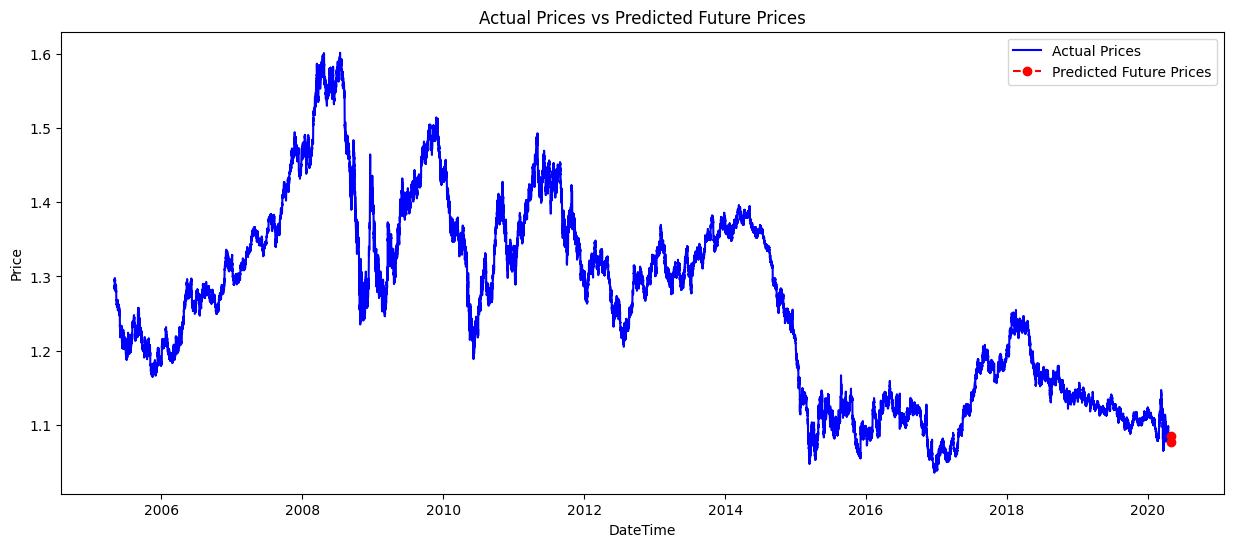

In [58]:
# Cell 9: Plot Historical Data with Future Predictions
def plot_known_and_predicted(df, predicted_prices, future_steps=10):
    # Get the actual closing prices from the original dataframe (assume 'BC' is the closing price column)
    actual_prices = df['BC'].values

    # Create a time index for the future predictions
    last_known_time_index = df.index[-1]
    future_time_index = pd.date_range(start=last_known_time_index, periods=future_steps + 1, freq='h')[1:]  # Assuming hourly frequency

    # Plot the known actual prices
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, actual_prices, color='blue', label='Actual Prices')

    # Plot the predicted future prices
    plt.plot(future_time_index, predicted_prices, color='red', marker='o', linestyle='dashed', label='Predicted Future Prices')

    # Adding titles and labels
    plt.title('Actual Prices vs Predicted Future Prices')
    plt.xlabel('DateTime')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Plot the actual and predicted prices
plot_known_and_predicted(df, predicted_future_prices, future_steps)

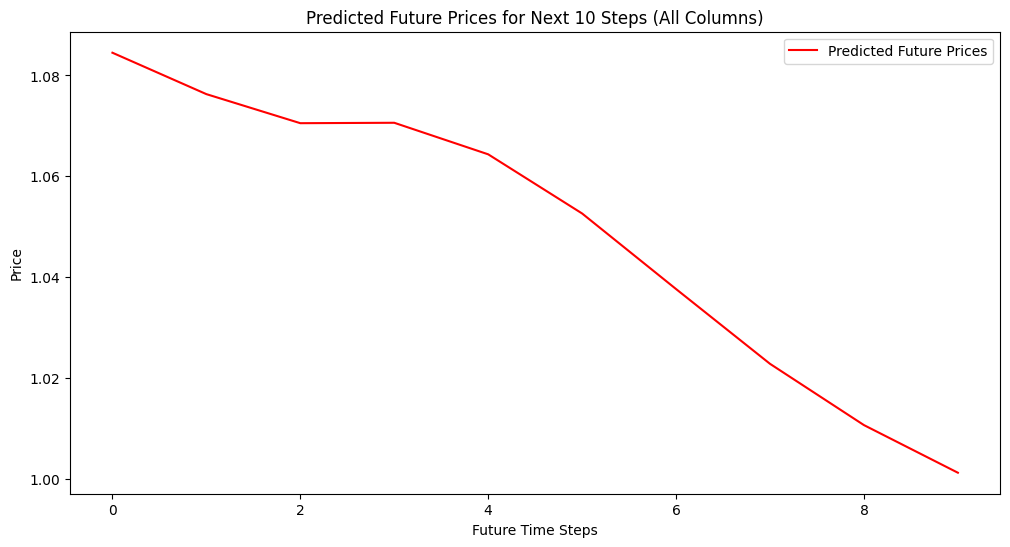

/kaggle/working/scaler.pkl

In [61]:
# Plot the predicted future prices (Example: Only showing the first column, BO, as an example)
plt.figure(figsize=(12, 6))
plt.plot(predicted_future_prices, color='red', label='Predicted Future Prices')
plt.title(f'Predicted Future Prices for Next {future_steps} Steps (All Columns)')
plt.xlabel('Future Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

from keras.models import load_model
from IPython.display import FileLink

# บันทึกโมเดล
model.save('model.h5')

# สร้างลิงก์สำหรับดาวน์โหลดทันที
FileLink('model.h5')

import joblib

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
FileLink('scaler.pkl')